In [1]:
from imageio import imread, imsave
import numpy as np
import cv2
import meshplot
from imageio import imread, imsave
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import meshplot as mp

# Problem 1

I referenced the following links:
- https://cseweb.ucsd.edu/classes/sp19/cse152-a/hw2/HW2.pdf
- https://stackoverflow.com/questions/46607647/sift-feature-matching-point-coordinates
- https://skoch9.github.io/meshplot/tutorial/#visualizing-point-clouds

In [2]:
def sampson_distance(F, x1, x2):
 
    # Compute sampson error for each correspondence.
    Fx1 = np.dot(F, x1)
    Fx2 = np.dot(F, x2)
    denom = Fx1[0]**2 + Fx1[1]**2 + Fx2[0]**2 + Fx2[1]**2
    err = ( np.diag(np.dot(x1.T, np.dot(F,x2))) )**2 / denom 

    # return error per point
    return err

def compute_epipole(F):
    """ Computes the (right) epipole from a
    fundamental matrix F.
    (Use with F.T for left epipole.) """
    
    # Fe_1 = 0, thus need to return null space of F (Fx = 0)
    U, S, V = np.linalg.svd(F)
    e = V[-1]
    return e / e[2]

def plot_epipolar_line(im, F, x, epipole=None, show_epipole=True, start=0):
    """ Plot the epipole and epipolar line F*x=0
        in an image. F is the fundamental matrix 
        and x a point in the other image."""
    
    m,n = im.shape[:2]
    line = np.dot(F,x)
    
    # epipolar line parameter and values
    t = np.linspace(start,n,100)
    lt = np.array([(line[2]+line[0]*tt)/(-line[1]) for tt in t])

    # take only line points inside the image
    ndx = (lt>=0) & (lt<m) 
    plt.plot(t[ndx],lt[ndx],linewidth=2)
    
    if show_epipole:
        if epipole is None:
            epipole = compute_epipole(F)
        plt.plot(epipole[0]/epipole[2],epipole[1]/epipole[2],'r*')

def compute_fundamental(x1,x2):
    """ Computes the fundamental matrix from corresponding points
    (x1,x2 3xn arrays) using the 8 point algorithm.
    each row is constructed as
    [x’*x, x’*y, x’, y’*x, y’*y, y’, x, y, 1] """
    
    n = x1.shape[1]
    A = np.zeros((n, 9))
    for i in range(n):
        A[i] = [
            x1[0, i] * x2[0, i], x1[0, i] * x2[1, i], x1[0, i] * x2[2, i],
            x1[1, i] * x2[0, i], x1[1, i] * x2[1, i], x1[1, i] * x2[2, i],
            x1[2, i] * x2[0, i], x1[2, i] * x2[1, i], x1[2, i] * x2[2, i]
        ]
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    return F / F[2, 2]

def compute_fundamental_normalized(x1,x2):
    """    Computes the fundamental matrix from corresponding points 
        (x1,x2 3xn arrays) using the normalized 8 point algorithm. """

    # normalize image coordinates
    x1n = x1 / x1[2]
    mean1 = np.mean(x1[:2], axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([
        [S1, 0, -S1 * mean1[0]],
        [0, S1, -S1 * mean1[1]],
        [0, 0, 1]
    ])
    x1n = np.dot(T1, x1n)
    
    x2n = x2 / x2[2]
    mean2 = np.mean(x2[:2], axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([
        [S2, 0, -S2 * mean2[0]],
        [0, S2, -S2 * mean2[1]],
        [0, 0, 1]
    ])
    x2n = np.dot(T2, x2n)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1n, x2n)

    # undo normalization
    F = np.dot(T1.T, np.dot(F, T2))

    return F / F[2,2]

def skew(a):
    """ Skew matrix A such that a x v = Av for any v. """
    return np.array([[0,-a[2],a[1]],[a[2],0,-a[0]],[-a[1],a[0],0]])

def make_homog(points):
    return np.vstack((points, np.ones((1, points.shape[1]))))

def triangulate_point(x1, x2, P1, P2):
    """ Helper func to triangulate a single point """
    M = np.zeros((6, 6))
    M[:3, :4] = P1
    M[3:, :4] = P2
    M[:3, 4] = -x1
    M[3:, 5] = -x2

    U, S, V = np.linalg.svd(M)
    X = V[-1, :4]
    return X / X[3]

def triangulate(x1, x2, P1, P2):
    """    
    Two-view triangulation of points in x1,x2 (3xn homog. coordinates). 
    Return: 3xn point cloud
    """
    points = []
    for i in range(x1.shape[1]):
        point = triangulate_point(x1[:, i], x2[:, i], P1, P2)
        points.append(point)
    
    return np.array(points).T

def extract_correspondences(im1, im2, coeff=0.5):
    # similar to your panorama implementation, can copy/paste
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(im1, None)
    kp2, desc2 = sift.detectAndCompute(im2, None)
    matches = cv2.BFMatcher().knnMatch(desc1, desc2, k=2)
    
    matches_for_plot = []
    pts1 = []
    pts2 = []
    for m1, m2 in matches:
        if m1.distance > coeff * m2.distance:
            continue
        matches_for_plot.append([m1])
        pt1 = kp1[m1.queryIdx].pt
        pt2 = kp2[m1.trainIdx].pt
        pts1.append(pt1)
        pts2.append(pt2)
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    return pts1, pts2, matches_for_plot, kp1, kp2

In [3]:
merton1 = imread("data/merton1.jpg")
merton2 = imread("data/merton2.jpg")

In [4]:
pts1, pts2, matches_for_plot, kp1, kp2 = extract_correspondences(
    merton1, merton2, coeff=0.3)

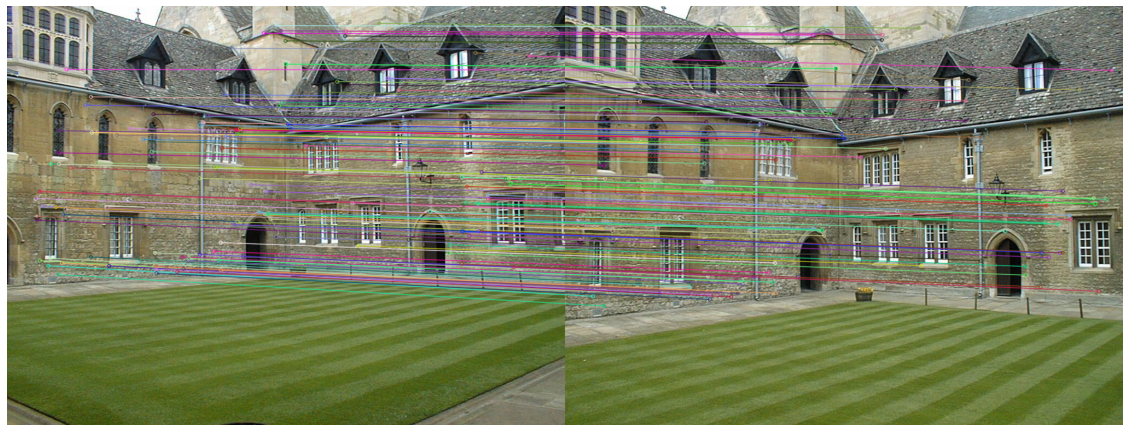

In [5]:
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(merton1, kp1, merton2,
                          kp2, matches_for_plot, None,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(img3)
plt.show()

In [6]:
# Sampson error

x1 = pts1
x2 = pts2
x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

F = compute_fundamental(x1, x2)

error = sampson_distance(F, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error: {}".format(np.mean(error)))

10.2145213530057
Average Sampson error: 72.67780817488426


In [7]:
# normalized Sampson

F_hat = compute_fundamental_normalized(x1, x2)
error = sampson_distance(F_hat, make_homog(pts1.T), make_homog(pts2.T))
print(np.median(error))
print("Average Sampson error using normalized fundamental matrix: {}".format(np.mean(error)))

7.09586074937511
Average Sampson error using normalized fundamental matrix: 22.12284582683076


## Answer to Problem 1.2

The Sampson error for $\hat F$ computed from the normalized 8-point algorithm is smaller than the error for $\tilde F$ computed from the vanilla 8-point algorithm. We observe a significant improvement from normalizing.

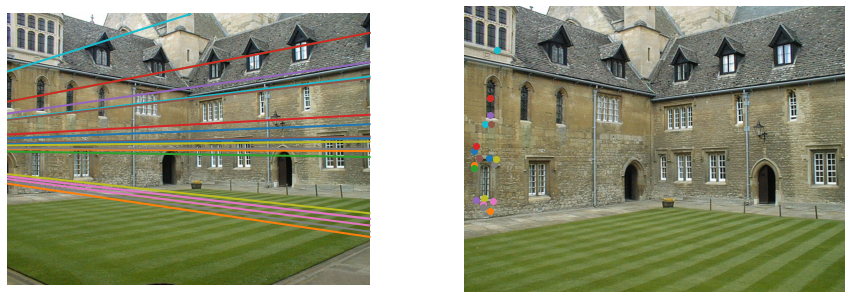

In [8]:
# Epiline plotting

rand_ind = np.random.permutation(pts2.shape[0])

e = compute_epipole(F)

plt.figure(1, figsize=(15,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(merton1)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, False)

plt.subplot(122)
 
plt.axis('off')
plt.imshow(merton2)

for i in range(20):
    plt.plot(x2[0,i],x2[1,i],'o')
    

plt.show()

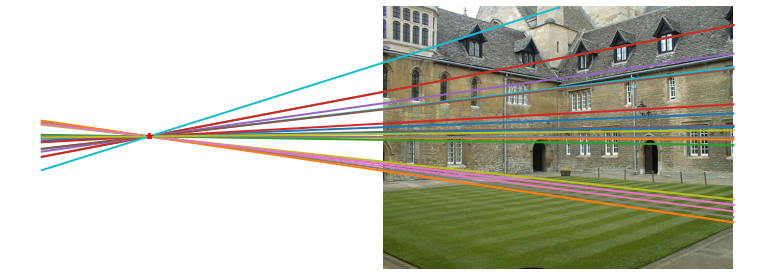

In [9]:
# Epipole plotting

plt.figure(1, figsize=(30,20))

plt.subplot(122)
plt.axis('off')
plt.imshow(merton1)

plt.figure(1, figsize=(15,10))

e = compute_epipole(F.T)

for i in range(20):
    x = make_homog(pts1.T).T[rand_ind[i],:]
    plot_epipolar_line(merton1, F, x2[:,i], e, True, start=-1000)

    
plt.show()

In [51]:
# Triangulation

P1 = np.loadtxt("data/001.P")
P2 = np.loadtxt("data/002.P")

pts1, pts2, match_for_plot, kp1, kp2 = extract_correspondences(merton1, merton2, coeff=0.8)

x1 = pts1
x2 = pts2

x1 = make_homog(x1.T)
x2 = make_homog(x2.T)

pts1_int = pts1.astype(int)
pts2_int = pts2.astype(int)

colors = []

for i in range(pts1_int.shape[0]):
    u, v = pts1_int[i,:]
    colors.append(merton1[v, u,:]/255.)
    
colors = np.array(colors)
points_est = triangulate(x1, x2, P1, P2)[:3,:].T

In [50]:
pts1

array([[   3.4194417 ,  718.64300537],
       [   7.62814474,  177.5725708 ],
       [  10.60264778,   11.11931992],
       ...,
       [1015.90478516,  397.51223755],
       [1016.06958008,   88.97293091],
       [1020.47949219,  504.0821228 ]])

In [48]:
x1

array([[3.41944170e+00, 7.62814474e+00, 1.06026478e+01, ...,
        1.01590479e+03, 1.01606958e+03, 1.02047949e+03],
       [7.18643005e+02, 1.77572571e+02, 1.11193199e+01, ...,
        3.97512238e+02, 8.89729309e+01, 5.04082123e+02],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [23]:
x1.shape

(3, 3037)

In [29]:
X = cv2.triangulatePoints(
            P1, 
            P2, 
            x1[:2] / x1[2] , 
            x2[:2] / x2[2]
            ).transpose()
X /= X[3]

In [32]:
X.shape

(3037, 4)

In [34]:

X

array([[ 0.4255099 ,  0.94473962,  1.11893923,  0.84603332],
       [ 1.61749137,  1.07287171,  0.78822642,  1.23474905],
       [ 0.92707274,  0.98291369,  1.03604585,  0.96410811],
       ...,
       [ 0.21393557, -1.23311421, -0.21516016,  0.43629466],
       [ 1.169     , -1.09699631, -0.77224004, -0.2672951 ],
       [ 0.25479662,  1.0414186 ,  0.94321737,  0.54109799]])

In [54]:
X = cv2.triangulatePoints(
            P1, 
            P2, 
            pts1.T, 
            pts2.T
            ).transpose()
X /= X[3]

In [56]:
X, X.shape

(array([[ 0.4255099 ,  0.94473962,  1.11893923,  0.84603332],
        [ 1.61749137,  1.07287171,  0.78822642,  1.23474905],
        [ 0.92707274,  0.98291369,  1.03604585,  0.96410811],
        ...,
        [ 0.21393557, -1.23311421, -0.21516016,  0.43629466],
        [ 1.169     , -1.09699631, -0.77224004, -0.2672951 ],
        [ 0.25479662,  1.0414186 ,  0.94321737,  0.54109799]]),
 (3037, 4))

In [27]:
points_est

array([[ 2.41169147, 14.23153502, 11.28963497],
       [ 2.96547175, 12.29748715,  6.51249643],
       [ 6.02089997, 10.35905638,  1.78500369],
       ...,
       [ 1.39883049, 38.60974923, 21.25131396],
       [ 0.51516913, 18.9010577 , 14.70708444],
       [ 1.4773362 , 12.77350128, 12.52063061]])

In [57]:
mp.plot(v=X[:, :3])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0263848…

In [13]:
d = mp.subplot(v=points_est, c=colors, s=[1, 2, 0], shading={"point_size": 0.5})

## Problem 1.4

The point cloud I got roughly matches the structure I would infer from just looking at the image.

# Problem 2

[Original paper](https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf)

In [61]:
import math
from skimage import io, color
import numpy as np
from tqdm import trange

# note: you can convert to LAB with lab_arr = color.rgb2lab(rgb)

## Problem 2.1

When we increase compactness parameter $m$, the spatial distance $d_{xy}$ gains more weight in the final distance $D_s$. With a fixed $d_{lab}$, $D_s$ will increase and the pixel will be more likely to fall out of the $2S\times2S$ window. This emphasis on spatial proximity results in a more compact cluster assignment, hence the name.

In [140]:
class SLIC:
    def __init__(self, file_path, K, M):
        self.img_rgb = imread(file_path)
        self.img_lab = color.rgb2lab(self.img_rgb)
        self.img_width = self.img_rgb.shape[0]
        self.img_height = self.img_rgb.shape[1]
        
        # N
        self.num_pixels = self.img_width * self.img_height
        self.num_clusters = K
        self.compactness = M
        # S
        self.window_len_half = int(math.sqrt(self.num_pixels / K))
        
        # initialize cluster centers, each a len-5 np array (lab_k, xy_k)
        self.cluster_centers = []
        self.num_clusters_actual = 0 # might be different from K
        for x in range(self.window_len_half, 
                       self.img_width - self.window_len_half, 
                       self.window_len_half):
            for y in range(self.window_len_half, 
                           self.img_height - self.window_len_half, 
                           self.window_len_half):
                self.num_clusters_actual += 1
                lab = self.img_lab[x, y]
                center = np.array([lab[0], lab[1], lab[2], x, y])
                self.cluster_centers.append(center)
        
        # each holds an index into self.cluster_centers
        self.pixel_assignments = np.empty((self.img_width, self.img_height))
        
    def compute_distance(self, arr1_5d, arr2_5d):
        lab_k, xy_k = arr1_5d[:3], arr1_5d[3:]
        lab_i, xy_i = arr2_5d[:3], arr2_5d[3:]
        dist_lab = np.linalg.norm(lab_k - lab_i)
        dist_xy = np.linalg.norm(xy_k - xy_i)
        dist = dist_lab + self.compactness / self.window_len_half * dist_xy
        return dist
    
    def iterate(self):
        # for each pixel, locate cluster centers it's eligible for
        # i.e. cluster centers that has the pixel in their 2S x 2S window
        # compute all distances and take min
        for x in range(self.img_width):
            for y in range(self.img_height):
                # this pixel
                lab = self.img_lab[x, y]
                pixel = np.array([lab[0], lab[1], lab[2], x, y])
                # record cluster index
                cluster_indices = []
                distances = []
                for idx, center in enumerate(self.cluster_centers):
                    _, _, _, xx, yy = center
                    is_eligible = (xx - 2 * self.window_len_half
                                   <= x <= xx + 2 * self.window_len_half)
                    is_eligible &= (yy - 2 * self.window_len_half
                                   <= y <= yy + 2 * self.window_len_half)
                    if is_eligible:
                        cluster_indices.append(idx)
                        # compute distance
                        dist = self.compute_distance(center, pixel)
                        distances.append(dist)
                # find best cluster, min dist
                best_idx = np.argmin(distances)
                best_cluster = cluster_indices[best_idx]
                self.pixel_assignments[x, y] = best_cluster
                
        # recompute clusters
        new_cluster_centers = []
        for idx in range(self.num_clusters_actual):
            # find cluster member
            pixel_indices = np.argwhere(self.pixel_assignments == idx)
            # average xy
            xy = pixel_indices.mean(axis=0).astype(int)
            # average lab
            lab = self.img_lab[tuple(pixel_indices.T)].mean(axis=0)
            new_center = np.array([lab[0], lab[1], lab[2], xy[0], xy[1]])
            new_cluster_centers.append(new_center)
        self.cluster_centers = new_cluster_centers
    
    def visualize_clusters(self):
        """ return rgb image to plot using matplolib """
        img_cluster_lab = np.empty((self.img_width, self.img_height, 3))

        for idx in range(self.num_clusters_actual):
            # find cluster member
            pixel_indices = np.argwhere(p.pixel_assignments == idx)
            lab = self.cluster_centers[idx][:3]
            img_cluster_lab[tuple(pixel_indices.T)] = lab

        img_cluster_rgb = color.lab2rgb(img_cluster_lab)
        return img_cluster_rgb

In [144]:
def visualize_clusters(slic_obj):
    img_cluster_rgb = slic_obj.visualize_clusters()
    plt.imshow(img_cluster_rgb)
    plt.axis('off')
    # use red dot to denote cluster center
    for center in slic_obj.cluster_centers:
        _, _, _, x, y = center
        # XXX: why is the order of x, y reversed?
        plt.plot(y, x, 'r.')
    plt.show()

In [141]:
p = SLIC('data/elon.png', K=50, M=40)
for i in trange(5):
    p.iterate()

100%|██████████| 5/5 [06:23<00:00, 76.70s/it]


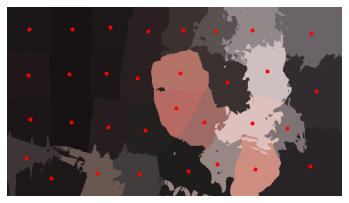

In [145]:
visualize_clusters(p)